# Importando as bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pymannkendall import original_test
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm.auto import tqdm

from db import connection_db as conndb
from db import filters
from utils.estracao_interacao import ExtracaoInteracao

tqdm.pandas()

# Conectando ao banco de dados do MongoDB

Função para conectar ao MongoDB

In [2]:
def conectar_mongodb(uri, db_name, collection_name):
    mongo_connection = conndb.MongoDBConnection(uri=uri, database_name=db_name, collection_name=collection_name)
    mongo_connection.connect()
    return mongo_connection.collection

In [3]:
# Definindo os parâmetros de conexão
uri = 'mongodb://localhost:27017/'
db_name = 'dadosVivamente'
collection_name = 'dadosSemFiltros'
collection_name_filtered = 'posts7anos1anos'

collection = conectar_mongodb(uri, db_name, collection_name)
collection_filtrada = conectar_mongodb(uri, db_name, collection_name_filtered)

Conexão estabelecida com sucesso ao banco de dados.
Conexão estabelecida com sucesso ao banco de dados.


# Aplicando pipeline para preparação dos dados

Função para aplicar os pipelines de filtro

In [4]:
def aplicar_pipelines(collection, collection_filtrada):
    collection_filters = filters.CollectionFilters(collection)
    collection_filters_likes = filters.CollectionFilters(collection_filtrada)

    # Aplicar pipelines
    collection_filters.apply_pipeline1('dadosComFiltrosIniciais')
    collection_filters.apply_pipeline2(7, 1, 'posts7anos1anos')
    collection_filters.apply_pipeline3('postsComBDIAndInfos')
    collection_filters.apply_pipeline4('posts')
    collection_filters_likes.apply_pipeline6('likes')

    return collection_filters.collection, collection_filters_likes.collection

In [5]:
# Aplicando os pipelinesc
collection, collection_filtrada = aplicar_pipelines(collection, collection_filtrada)

INFO:root:A coleção já existe: dadosComFiltrosIniciais
INFO:root:A coleção já existe: posts7anos1anos
INFO:root:A coleção já existe: postsComBDIAndInfos
INFO:root:A coleção já existe: posts
INFO:root:A coleção já existe: likes


# Carregando os dados em um dataframe

In [6]:
documentos = collection.find()
df_original = pd.DataFrame(list(documentos))

In [7]:
# Visualizar as primeiras linhas do dataframe
df_original.head()

,_id,idade,sexo,id_usuario,pessimismo,tristeza,fracasso,prazer,culpa,punicao,...,irritabilidade,apetite,concentracao,fadiga,int_sexo,quantAmigos,postMessage,postStory,postCreatedTime,diaDaSemana
0,5922035323c873001d525745,23,F,1743509662331356,0,1,1,0,0,0,...,2,0,2,1,1,690,"Marry, acho mesmo que sou de exatas...rs",Michele Kreski shared a video to your Timeline.,2017-05-07 20:42:01,Domingo
1,5922035323c873001d525746,23,F,1743509662331356,0,1,1,0,0,0,...,2,0,2,1,1,690,A foto não está muito boa (porque o foco é a b...,Michele Kreski with Stephani Kreski and 3 others.,2017-05-03 14:56:38,Quarta-feira
2,5922035323c873001d525747,23,F,1743509662331356,0,1,1,0,0,0,...,2,0,2,1,1,690,Hahahahahaha,Thais Belarmino shared Paródia dos Nomes's pho...,2017-03-21 16:40:15,Terça-feira
3,5922035323c873001d525748,23,F,1743509662331356,0,1,1,0,0,0,...,2,0,2,1,1,690,NaN,Daniel Brito and 10 others wrote on your Timel...,2017-03-12 00:35:55,Domingo
4,5922035323c873001d525749,23,F,1743509662331356,0,1,1,0,0,0,...,2,0,2,1,1,690,Parabéns Mariana Kreski foto top hahahhahhahha...,NaN,2017-03-10 18:19:35,Sexta-feira


In [8]:
documentos_likes = collection_filtrada.find()
df_original_likes = pd.DataFrame(list(documentos_likes))

In [9]:
# Visualizar as primeiras linhas do dataframe
df_original_likes.head()

,_id,id_usuario,likeCreatedTime
0,5922035323c873001d52562f,1743509662331356,2017-05-18 23:31:26
1,5922035323c873001d525630,1743509662331356,2017-05-09 21:32:15
2,5922035323c873001d525631,1743509662331356,2017-05-02 21:16:06
3,5922035323c873001d525632,1743509662331356,2017-04-19 17:33:47
4,5922035323c873001d525633,1743509662331356,2017-04-12 11:23:27


In [10]:
# Transformando a coluna sexo em binária
df_original['sexo'] = df_original['sexo'].map({'F': 0, 'M': 1})

# Removendo colunas desnecessárias
df_original.drop(columns=['_id', 'diaDaSemana'], inplace=True)

# Lista de colunas que precisam ser convertidas
colunas_para_converter = [
    'pessimismo', 'tristeza', 'fracasso', 'prazer', 'culpa', 'punicao', 'estima', 'critica', 'suicida', 'choro',
    'agitacao', 'interesse', 'indecisao', 'desvalorizacao', 'energia', 'sono', 'irritabilidade', 'apetite',
    'concentracao', 'fadiga', 'int_sexo', 'quantAmigos'
]


# Função para preencher valores nulos e converter o tipo de dado
def preencher_e_converter(df, colunas, valor_preenchimento=0, tipo_dados='int64'):
    df[colunas] = df[colunas].fillna(valor_preenchimento)
    df[colunas] = df[colunas].astype(tipo_dados)
    return df

In [11]:
df_original = preencher_e_converter(df_original, colunas_para_converter)

In [12]:
df_original.head()

,idade,sexo,id_usuario,pessimismo,tristeza,fracasso,prazer,culpa,punicao,estima,...,sono,irritabilidade,apetite,concentracao,fadiga,int_sexo,quantAmigos,postMessage,postStory,postCreatedTime
0,23,0,1743509662331356,0,1,1,0,0,0,1,...,0,2,0,2,1,1,690,"Marry, acho mesmo que sou de exatas...rs",Michele Kreski shared a video to your Timeline.,2017-05-07 20:42:01
1,23,0,1743509662331356,0,1,1,0,0,0,1,...,0,2,0,2,1,1,690,A foto não está muito boa (porque o foco é a b...,Michele Kreski with Stephani Kreski and 3 others.,2017-05-03 14:56:38
2,23,0,1743509662331356,0,1,1,0,0,0,1,...,0,2,0,2,1,1,690,Hahahahahaha,Thais Belarmino shared Paródia dos Nomes's pho...,2017-03-21 16:40:15
3,23,0,1743509662331356,0,1,1,0,0,0,1,...,0,2,0,2,1,1,690,NaN,Daniel Brito and 10 others wrote on your Timel...,2017-03-12 00:35:55
4,23,0,1743509662331356,0,1,1,0,0,0,1,...,0,2,0,2,1,1,690,Parabéns Mariana Kreski foto top hahahhahhahha...,NaN,2017-03-10 18:19:35


In [13]:
# Função para manipular datas e filtrar posts
def manipular_e_filtrar_posts(df):
    df['data'] = df['postCreatedTime'].dt.date
    df['data'] = pd.to_datetime(df['data'])
    df['mes'] = df['data'].dt.to_period('M')
    df['semana'] = df['data'].dt.to_period('W')

    df_data = df[df['data'].dt.year == 2017]
    df_data = df_data[~((df_data['data'].dt.month == 12) & (df_data['data'].dt.year == 2017))]
    df_data = df_data[df_data['data'].dt.month >= 5]
    df_data = df_data[df_data['suicida'] == 3]

    # Remover posts vazios
    df_data = df_data.dropna(subset=['postMessage', 'postStory'], how='all')
    df_data = df_data[~((df_data['postMessage'].str.strip() == '') & (df_data['postStory'].str.strip() == ''))]

    return df_data

In [14]:
df_posts = manipular_e_filtrar_posts(df_original)
df_posts.head()

,idade,sexo,id_usuario,pessimismo,tristeza,fracasso,prazer,culpa,punicao,estima,...,concentracao,fadiga,int_sexo,quantAmigos,postMessage,postStory,postCreatedTime,data,mes,semana
69603,27,0,1870214326566563,2,1,1,3,2,1,1,...,2,3,3,532,NaN,Gabriela Tedesco shared Chloe's photo.,2017-06-08 16:01:43,2017-06-08,2017-06,2017-06-05/2017-06-11
69604,27,0,1870214326566563,2,1,1,3,2,1,1,...,2,3,3,532,Mini pizza 😍😍😍,NaN,2017-06-08 15:56:50,2017-06-08,2017-06,2017-06-05/2017-06-11
69605,27,0,1870214326566563,2,1,1,3,2,1,1,...,2,3,3,532,Os pães de hj 😍😘😍,NaN,2017-06-08 01:51:16,2017-06-08,2017-06,2017-06-05/2017-06-11
69606,27,0,1870214326566563,2,1,1,3,2,1,1,...,2,3,3,532,Amo um carinho da minha mãe 😍😍😍,NaN,2017-06-08 01:12:01,2017-06-08,2017-06,2017-06-05/2017-06-11
69607,27,0,1870214326566563,2,1,1,3,2,1,1,...,2,3,3,532,NaN,Gabriela Tedesco shared Chloe's photo.,2017-06-07 23:41:27,2017-06-07,2017-06,2017-06-05/2017-06-11


In [15]:
# Função para manipular datas e filtrar posts
def manipular_e_filtrar_likes(df):
    df['data'] = df['likeCreatedTime'].dt.date
    df['data'] = pd.to_datetime(df['data'])
    df['mes'] = df['data'].dt.to_period('M')
    df['semana'] = df['data'].dt.to_period('W')

    df_data = df[df['data'].dt.year == 2017]
    df_data = df_data[~((df_data['data'].dt.month == 12) & (df_data['data'].dt.year == 2017))]
    df_data = df_data[df_data['data'].dt.month >= 5]

    return df_data

In [16]:
df_likes = manipular_e_filtrar_likes(df_original_likes)

# Adicionar interações do usuário

In [17]:
extracao = ExtracaoInteracao(df_posts)
df_posts_interacoes = extracao.extract_interactions()

In [18]:
df_posts_interacoes.head()

,idade,sexo,id_usuario,pessimismo,tristeza,fracasso,prazer,culpa,punicao,estima,...,quantAddPhotoWithOthers,quantIsWithOthers,quantAddPhoto,quantSharedPhoto,quantSharedVideo,quantSharedLink,quantSharedPost,quantSharedEvent,quantSharedMemory,quantStatus
69603,27,0,1870214326566563,2,1,1,3,2,1,1,...,0,0,0,1,0,0,0,0,0,0
69604,27,0,1870214326566563,2,1,1,3,2,1,1,...,0,0,0,0,0,0,0,0,0,0
69605,27,0,1870214326566563,2,1,1,3,2,1,1,...,0,0,0,0,0,0,0,0,0,0
69606,27,0,1870214326566563,2,1,1,3,2,1,1,...,0,0,0,0,0,0,0,0,0,0
69607,27,0,1870214326566563,2,1,1,3,2,1,1,...,0,0,0,1,0,0,0,0,0,0


In [19]:
df_posts_interacoes.to_csv('df_posts_interacoes.csv', index=False)

Função para calcular e visualizar a distribuição de postagens por usuário

In [20]:
# Função para calcular e visualizar a distribuição de postagens por usuário
def distribuicao_posts(df, coluna_contagem, label_x, titulo):
    post_counts = df.groupby('id_usuario').size().reset_index(name=coluna_contagem)

    plt.hist(post_counts[coluna_contagem], bins=50)
    plt.xlabel(f'Número de {label_x}')
    plt.ylabel('Quantidade de Usuários')
    plt.title(titulo)
    plt.show()

    return post_counts

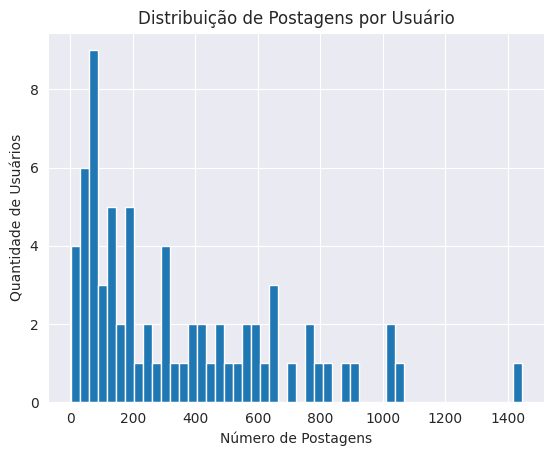

In [21]:
quant_posts = distribuicao_posts(df_posts_interacoes, 'post_count', 'Postagens',
                                 'Distribuição de Postagens por Usuário')

In [22]:
def distribuicao_postmessage(df, titulo):
    df_filtrado_msg = df[df['postMessage'].notnull() & df['postMessage'].str.strip() != '']

    post_counts_msg = df_filtrado_msg.groupby('id_usuario')['postMessage'].count().reset_index(name='quant_msg')

    plt.hist(post_counts_msg['quant_msg'], bins=50)
    plt.xlabel(f'Número de Postagens com Msg')
    plt.ylabel('Quantidade de Usuários')
    plt.title(titulo)
    plt.show()

    return post_counts_msg

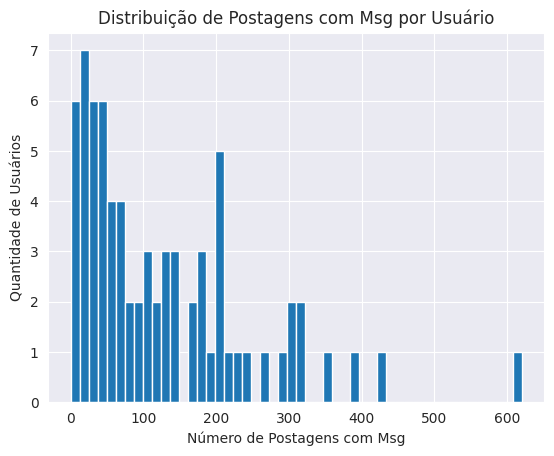

In [23]:
quant_msg = distribuicao_postmessage(df_posts_interacoes,
                                     'Distribuição de Postagens com Msg por Usuário')

In [24]:
def distribuicao_poststory(df, titulo):
    df_filtrado_story = df[df['postStory'].notnull() & df['postStory'].str.strip() != '']

    post_counts_story = df_filtrado_story.groupby('id_usuario')['postStory'].count().reset_index(name='quant_story')

    # Visualizar a distribuição
    plt.hist(post_counts_story['quant_story'], bins=50)
    plt.xlabel(f'Número de Postagens com Story')
    plt.ylabel('Quantidade de Usuários')
    plt.title(titulo)
    plt.show()

    return post_counts_story

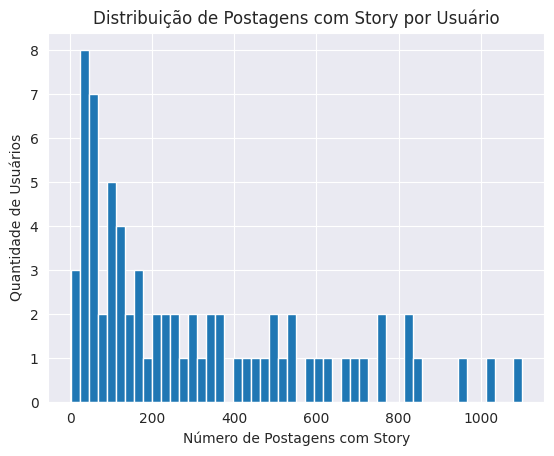

In [25]:
quant_story = distribuicao_poststory(df_posts_interacoes, 'Distribuição de Postagens com Story por Usuário')

In [26]:
def distribuicao_interacoes(df, coluna1, coluna2, coluna_contagem, label_x, titulo):
    if coluna2:
        interacoes = df.groupby('id_usuario')[[coluna1, coluna2]].sum().reset_index()
        interacoes[coluna_contagem] = interacoes[coluna1] + interacoes[coluna2]
    else:
        interacoes = df.groupby('id_usuario')[coluna1].sum().reset_index(name=coluna_contagem)

    plt.hist(interacoes[coluna_contagem], bins=50)
    plt.xlabel(label_x)
    plt.ylabel('Quantidade de Usuários')
    plt.title(titulo)
    plt.show()

    return interacoes

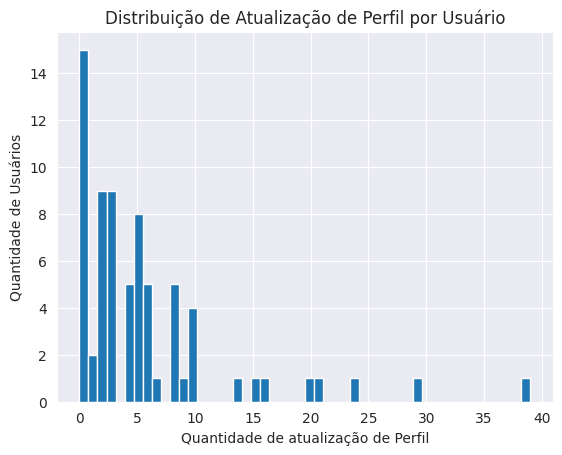

In [27]:
quant_profile_cover = distribuicao_interacoes(df_posts_interacoes, 'quantProfile', 'quantCover',
                                              'quant_profile_cover', 'Quantidade de atualização de Perfil',
                                              'Distribuição de Atualização de Perfil por Usuário')

In [28]:
# quantProfile,quantCover,quantAddPhotoWithOthers,quantIsWithOthers,quantAddPhoto,quantSharedPhoto,quantSharedVideo,quantSharedLink,quantSharedPost,quantSharedEvent,quantSharedMemory,quantStatus

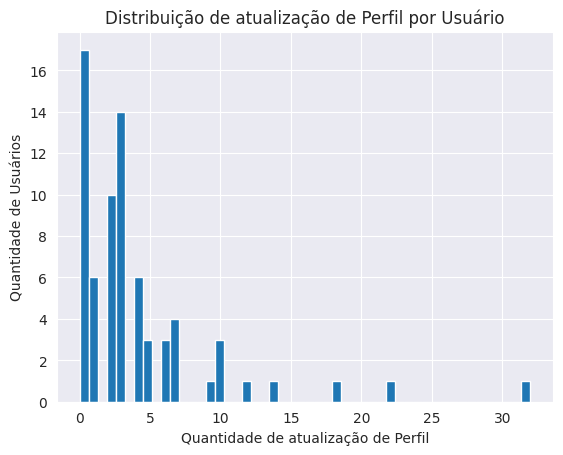

In [29]:
quant_profile = distribuicao_interacoes(df_posts_interacoes, 'quantProfile', None, 'quant_profile',
                                        'Quantidade de atualização de Perfil',
                                        'Distribuição de atualização de Perfil por Usuário')

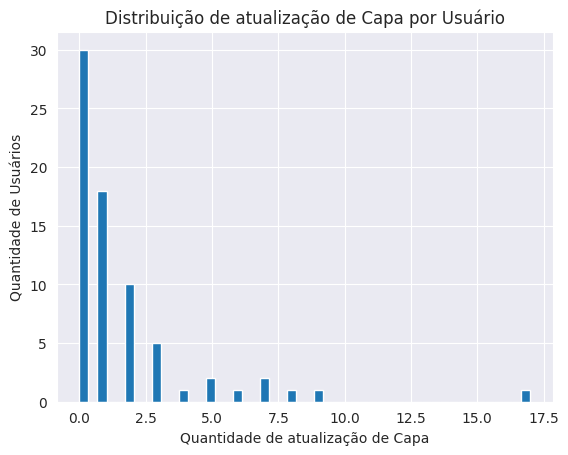

In [30]:
quant_cover = distribuicao_interacoes(df_posts_interacoes, 'quantCover', None, 'quant_cover',
                                      'Quantidade de atualização de Capa',
                                      'Distribuição de atualização de Capa por Usuário')

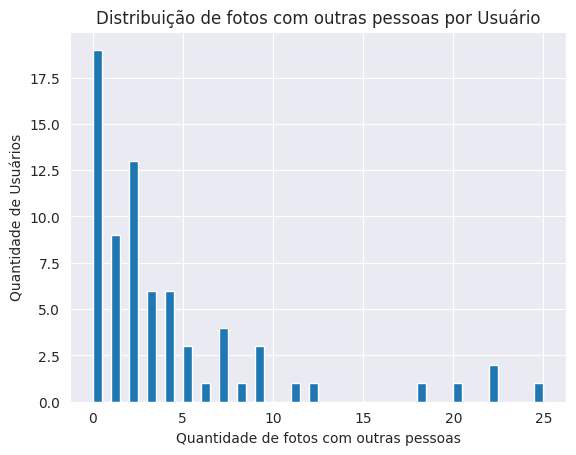

In [31]:
quant_photo_with_others = distribuicao_interacoes(df_posts_interacoes, 'quantAddPhotoWithOthers', None,
                                                  'quant_photo_with_others', 'Quantidade de fotos com outras pessoas',
                                                  'Distribuição de fotos com outras pessoas por Usuário')

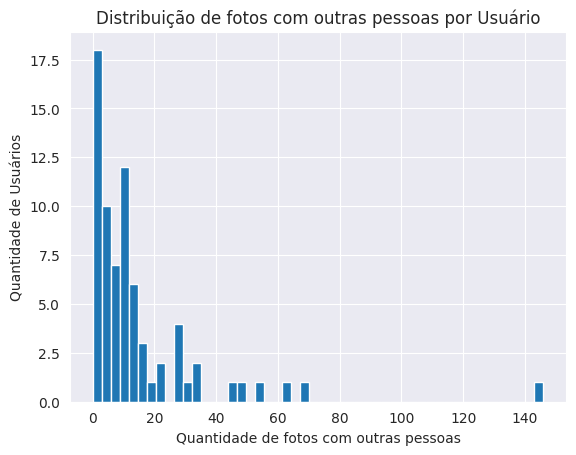

In [32]:
quant_is_with_others = distribuicao_interacoes(df_posts_interacoes, 'quantIsWithOthers', None,
                                               'quant_is_with_others', 'Quantidade de fotos com outras pessoas',
                                               'Distribuição de fotos com outras pessoas por Usuário')

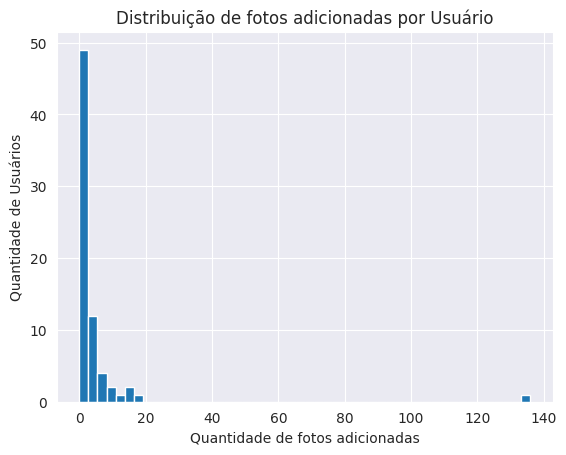

In [33]:
quant_add_photo = distribuicao_interacoes(df_posts_interacoes, 'quantAddPhoto', None,
                                          'quant_add_photo', 'Quantidade de fotos adicionadas',
                                          'Distribuição de fotos adicionadas por Usuário')

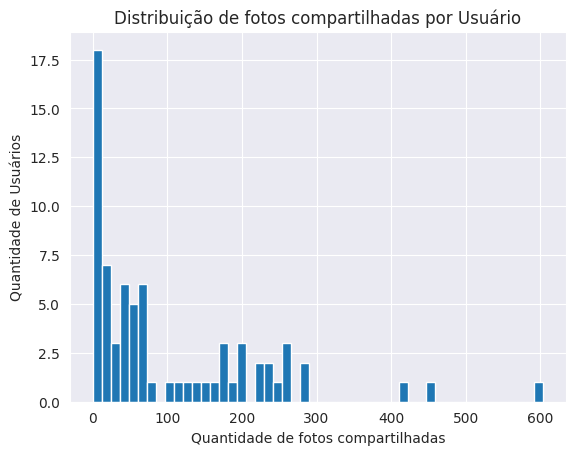

In [34]:
quant_shared_photo = distribuicao_interacoes(df_posts_interacoes, 'quantSharedPhoto', None,
                                             'quant_shared_photo', 'Quantidade de fotos compartilhadas',
                                             'Distribuição de fotos compartilhadas por Usuário')

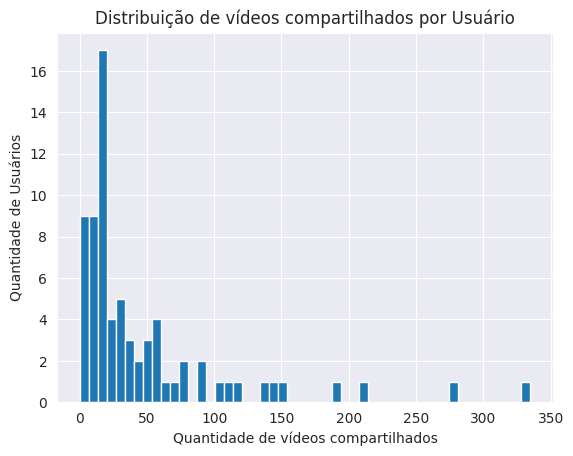

In [35]:
quant_shared_video = distribuicao_interacoes(df_posts_interacoes, 'quantSharedVideo', None,
                                             'quant_shared_video', 'Quantidade de vídeos compartilhados',
                                             'Distribuição de vídeos compartilhados por Usuário')

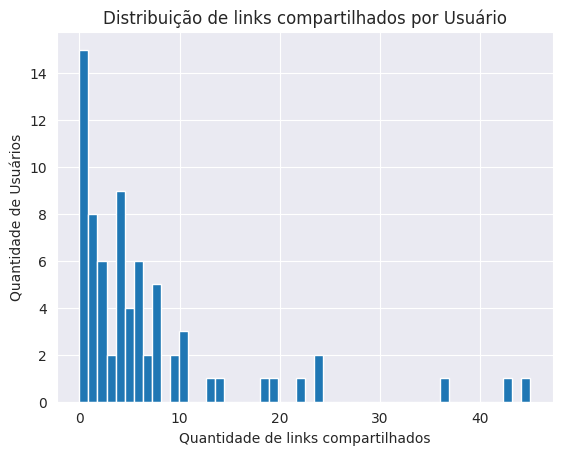

In [36]:
quant_shared_link = distribuicao_interacoes(df_posts_interacoes, 'quantSharedLink', None,
                                            'quant_shared_link', 'Quantidade de links compartilhados',
                                            'Distribuição de links compartilhados por Usuário')

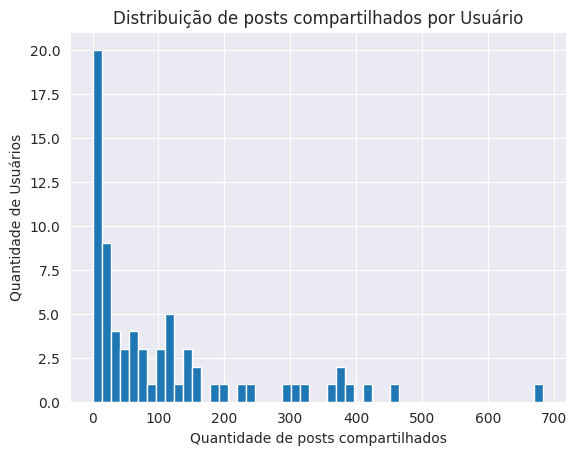

In [37]:
quant_shared_post = distribuicao_interacoes(df_posts_interacoes, 'quantSharedPost', None,
                                            'quant_shared_post', 'Quantidade de posts compartilhados',
                                            'Distribuição de posts compartilhados por Usuário')

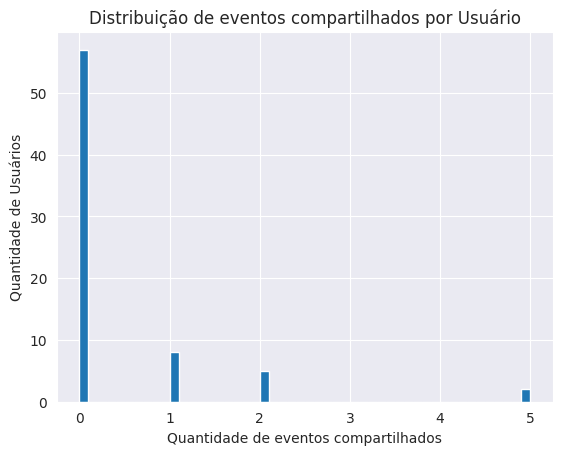

In [38]:
quant_shared_event = distribuicao_interacoes(df_posts_interacoes, 'quantSharedEvent', None,
                                             'quant_shared_event', 'Quantidade de eventos compartilhados',
                                             'Distribuição de eventos compartilhados por Usuário')

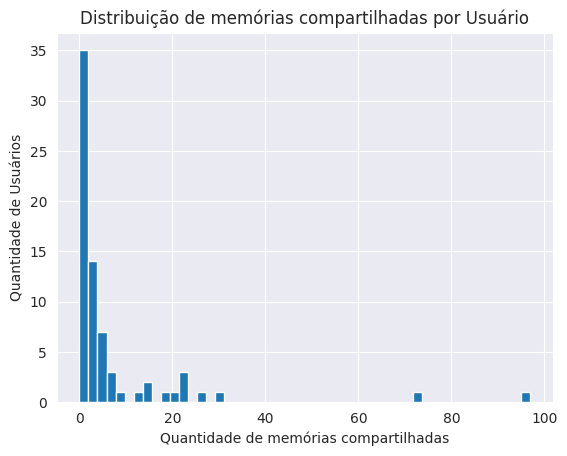

In [39]:
quant_shared_memory = distribuicao_interacoes(df_posts_interacoes, 'quantSharedMemory', None,
                                              'quant_shared_memory', 'Quantidade de memórias compartilhadas',
                                              'Distribuição de memórias compartilhadas por Usuário')

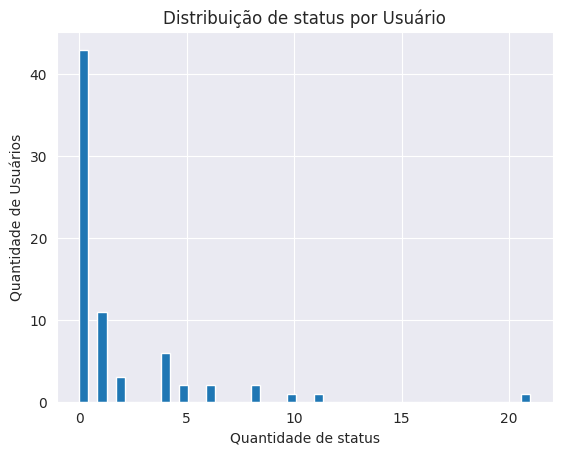

In [40]:
quant_status = distribuicao_interacoes(df_posts_interacoes, 'quantStatus', None,
                                       'quant_status', 'Quantidade de status',
                                       'Distribuição de status por Usuário')

In [41]:
def aplicar_kmeans(df, coluna_contagem, n_clusters=3, label_x='Postagens'):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    df['cluster'] = kmeans.fit_predict(df[[coluna_contagem]])

    sns.histplot(data=df, x=coluna_contagem, hue='cluster', bins=30, kde=True)
    plt.xlabel(f'Número de {label_x}')
    plt.ylabel('Frequência')
    plt.title(f'Distribuição dos Clusters de {label_x} por Usuário')
    plt.show()

    return kmeans, df

In [42]:
def calcular_silhouette_e_inercia(df, kmeans, coluna_contagem):
    silhouette_avg = silhouette_score(df[[coluna_contagem]], kmeans.labels_)
    inercia = kmeans.inertia_

    print(f'Silhouette Score médio: {silhouette_avg}')
    print(f'Inércia do modelo: {inercia}')

In [43]:
def calcular_inercia(df, coluna_contagem, max_clusters=10):
    inercia = []
    k = range(1, max_clusters + 1)
    for c in k:
        kmeans = KMeans(n_clusters=c, random_state=0)
        kmeans.fit(df[[coluna_contagem]])
        inercia.append(kmeans.inertia_)

    plt.plot(k, inercia, 'bx-')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inércia')
    plt.title('Método do Cotovelo para escolher o número ótimo de clusters')
    plt.show()

In [44]:
def calcular_distancias_cluster(df, kmeans, coluna_contagem):
    distancias_intracluster = cdist(df[[coluna_contagem]], kmeans.cluster_centers_[kmeans.labels_], 'euclidean')
    media_intracluster = distancias_intracluster.mean()

    distancias_intercluster = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, 'euclidean')
    media_intercluster = distancias_intercluster[np.triu_indices_from(distancias_intercluster, 1)].mean()

    print(f'Média das distâncias intracluster: {media_intracluster}')
    print(f'Média das distâncias intercluster: {media_intercluster}')

In [45]:
# Visualizar a distribuição
post_count = df_posts_interacoes.groupby('id_usuario').size().reset_index(name='quant_posts')

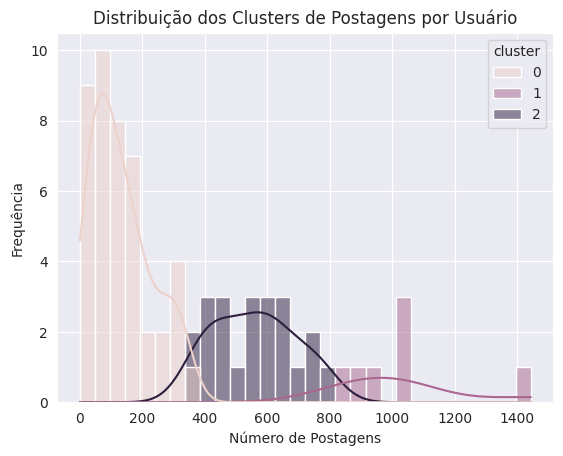

In [46]:
# Aplicando a função
kmeans, post_count_original = aplicar_kmeans(post_count, 'quant_posts', 3)

In [47]:
# Aplicando a função
calcular_silhouette_e_inercia(post_count, kmeans, 'quant_posts')

Silhouette Score médio: 0.6312687570886091
Inércia do modelo: 977319.3381153729


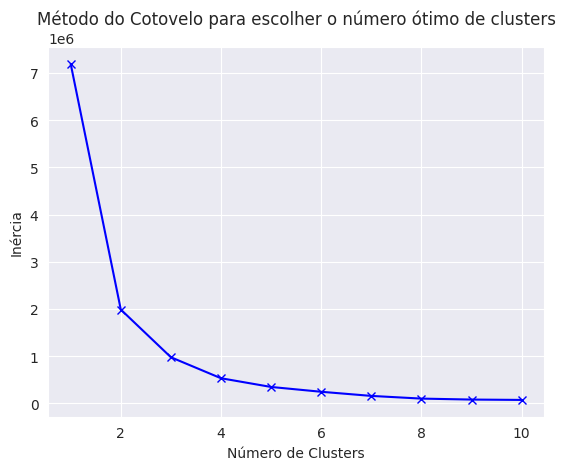

In [48]:
# Aplicando a função
calcular_inercia(post_count, 'quant_posts')

In [49]:
# Aplicando a função
calcular_distancias_cluster(post_count, kmeans, 'quant_posts')

Média das distâncias intracluster: 326.62770061728395
Média das distâncias intercluster: 596.4784053156146


In [50]:
def decompor_e_teste_mk(df_cluster, periodo, tipo_serie='posts'):
    resultados_mk = []

    for usuario in df_cluster['id_usuario'].unique():
        df_usuario = df_cluster[df_cluster['id_usuario'] == usuario]

        eventos_por_dia = df_usuario.groupby('data').size()

        if len(eventos_por_dia) >= 2 * periodo:
            try:
                resultado = seasonal_decompose(eventos_por_dia, model='additive', period=periodo)
                tendencia = resultado.trend.dropna()

                if len(tendencia) > 0:
                    result = original_test(tendencia)

                    if hasattr(result, 'trend'):
                        resultados_mk.append({
                            'id_usuario': usuario,
                            'trend': result.trend,
                            'h': result.h,
                            'p-valor': result.p,
                            'z': result.z,
                            'Tau': result.Tau,
                            's': result.s,
                            'var_s': result.var_s,
                            'slope': result.slope,
                            'intercept': result.intercept
                        })
                    else:
                        print(f"Usuário {usuario} - Resultado do teste de Mann-Kendall sem 'trend'.")
                else:
                    print(f"Usuário {usuario} - Não foi possível decompor dados suficientes para tendência.")
            except ValueError as e:
                print(f"Erro ao decompor a série para o usuário {usuario}: {e}")
        else:
            print(
                f"Usuário {usuario} não tem observações suficientes para decomposição. Necessário: {2 * periodo}, disponível: {len(eventos_por_dia)}")

    # Criando o DataFrame apenas se houver resultados suficientes
    if resultados_mk:
        df_resultados_mk = pd.DataFrame(resultados_mk)

        if 'trend' in df_resultados_mk.columns:
            contagem_tendencias = df_resultados_mk['trend'].value_counts()
            print(contagem_tendencias)

            total_usuarios = df_resultados_mk.shape[0]
            percentuais = (contagem_tendencias / total_usuarios) * 100
            print(percentuais)

            # Gráfico de barras das tendências
            plt.figure(figsize=(8, 6))
            sns.countplot(data=df_resultados_mk, x='trend', order=['increasing', 'decreasing', 'no trend'])
            plt.title(f'Distribuição de Tendências entre Usuários ({tipo_serie.capitalize()})')
            plt.xlabel('Tipo de Tendência')
            plt.ylabel('Número de Usuários')
            plt.show()

            # Gráfico de distribuição dos slopes
            plt.figure(figsize=(10, 6))
            sns.histplot(df_resultados_mk['slope'], bins=20, kde=True)
            plt.title(f'Distribuição dos Slopes entre Usuários ({tipo_serie.capitalize()})')
            plt.xlabel('Slope')
            plt.ylabel('Frequência')
            plt.show()

        else:
            print("Nenhuma tendência foi detectada nos dados.")

        return df_resultados_mk
    else:
        print("Nenhum dado disponível para análise.")
        return pd.DataFrame()

In [51]:
# Criar um DataFrame para cada cluster de postagens
df_cluster0 = df_posts_interacoes[
    df_posts_interacoes['id_usuario'].isin(post_count[post_count['cluster'] == 0]['id_usuario'])]

df_cluster1 = df_posts_interacoes[
    df_posts_interacoes['id_usuario'].isin(post_count[post_count['cluster'] == 1]['id_usuario'])]

df_cluster2 = df_posts_interacoes[
    df_posts_interacoes['id_usuario'].isin(post_count[post_count['cluster'] == 2]['id_usuario'])]

Usuário 923658871116552 não tem observações suficientes para decomposição. Necessário: 14, disponível: 1
Usuário 1959090184414965 não tem observações suficientes para decomposição. Necessário: 14, disponível: 1
Usuário 505494126499653 não tem observações suficientes para decomposição. Necessário: 14, disponível: 13
trend
no trend      16
decreasing    14
increasing    10
Name: count, dtype: int64
trend
no trend      40.0
decreasing    35.0
increasing    25.0
Name: count, dtype: float64


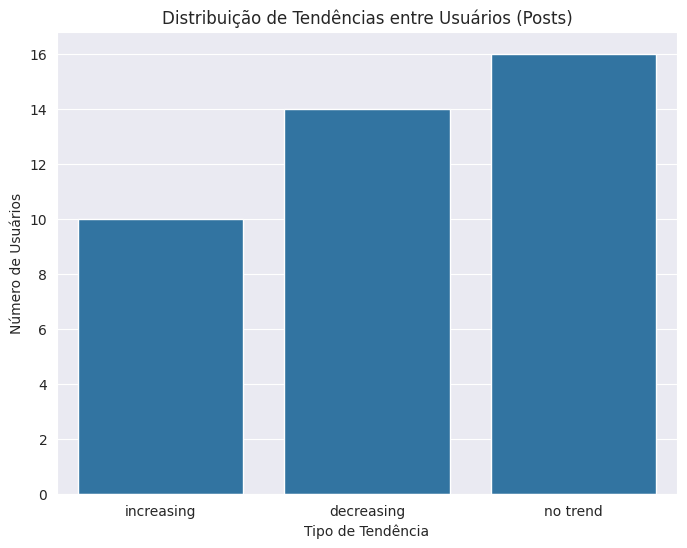

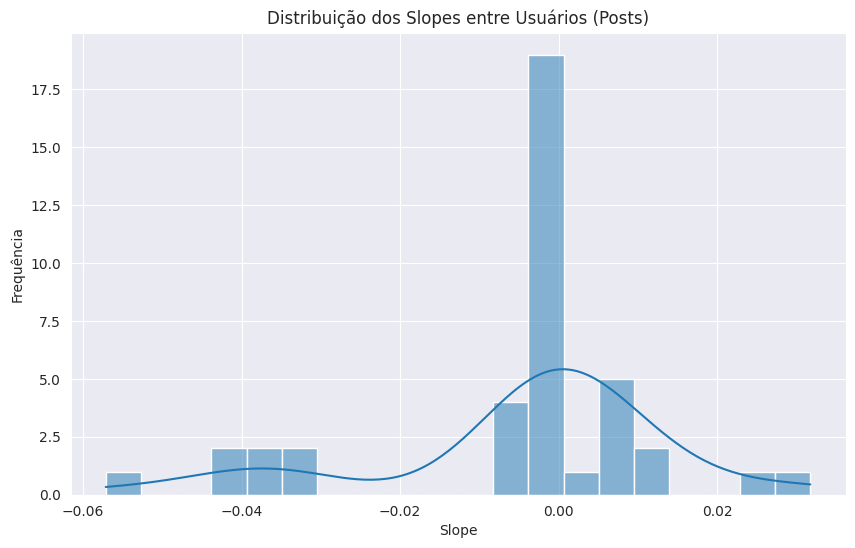

trend
increasing    4
decreasing    3
Name: count, dtype: int64
trend
increasing    57.142857
decreasing    42.857143
Name: count, dtype: float64


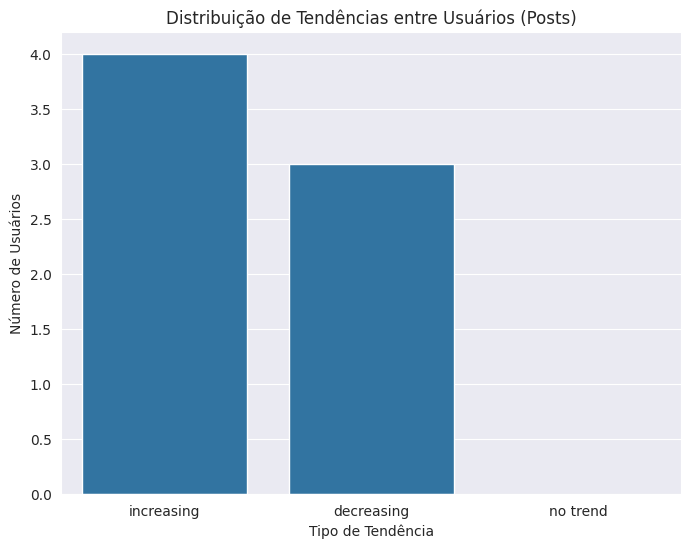

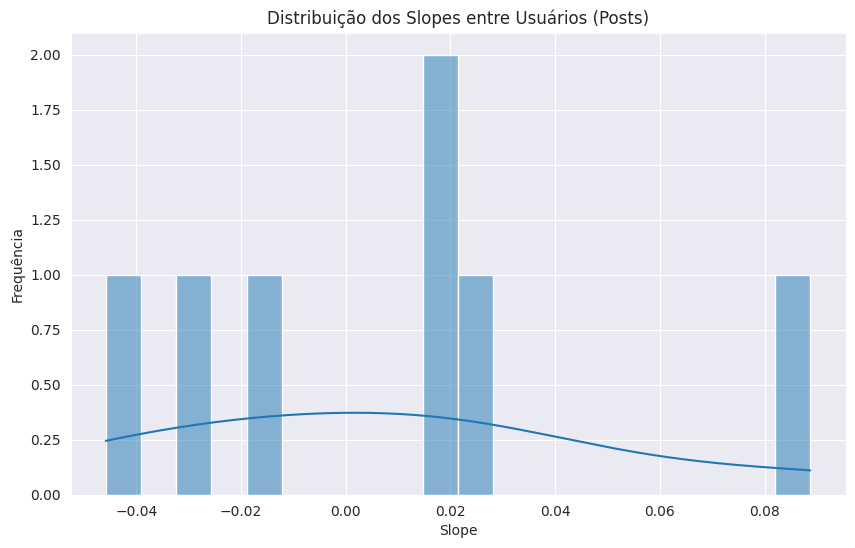

trend
decreasing    12
no trend       6
increasing     4
Name: count, dtype: int64
trend
decreasing    54.545455
no trend      27.272727
increasing    18.181818
Name: count, dtype: float64


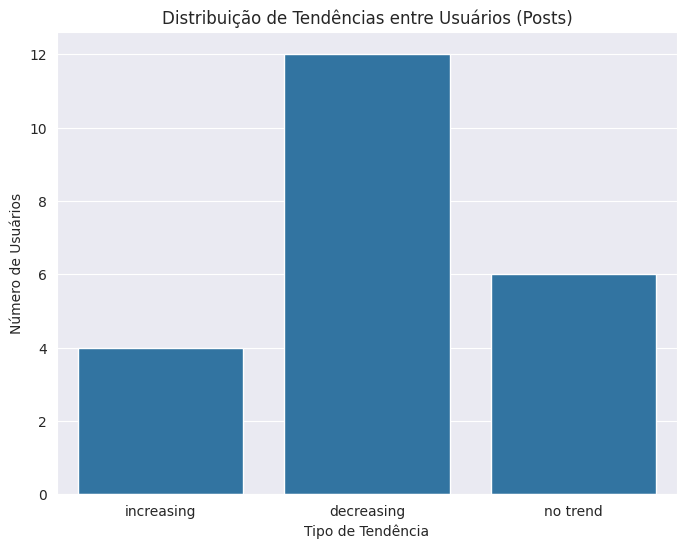

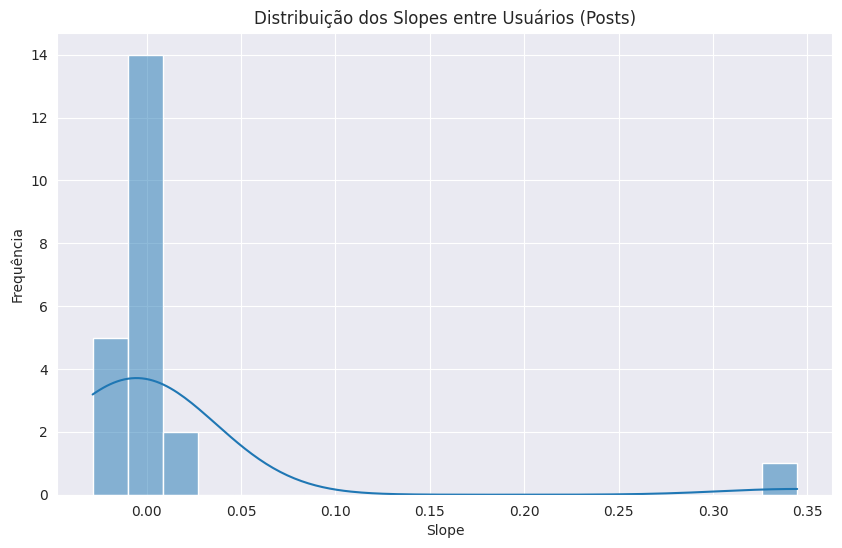

In [52]:
resultados_mk_original_cluster0 = decompor_e_teste_mk(df_cluster0, 7)
resultados_mk_original_cluster1 = decompor_e_teste_mk(df_cluster1, 7)
resultados_mk_original_cluster2 = decompor_e_teste_mk(df_cluster2, 7)

In [53]:
resultados_mk_original_cluster0.to_csv('resultados_mk_original_cluster0.csv', index=False)
resultados_mk_original_cluster1.to_csv('resultados_mk_original_cluster1.csv', index=False)
resultados_mk_original_cluster2.to_csv('resultados_mk_original_cluster2.csv', index=False)

In [54]:
df_cluster0.to_csv('df_cluster0.csv', index=False)
df_cluster1.to_csv('df_cluster1.csv', index=False)
df_cluster2.to_csv('df_cluster2.csv', index=False)

In [55]:
def calcular_e_plotar_media_respostas_bdi(df_cluster, nome_cluster):
    # Calcular as respostas médias do BDI para cada usuário no cluster
    df_respostas_bdi = df_cluster.groupby(['id_usuario']).agg(
        pessimismo=('pessimismo', 'first'),
        tristeza=('tristeza', 'first'),
        fracasso=('fracasso', 'first'),
        prazer=('prazer', 'first'),
        culpa=('culpa', 'first'),
        punicao=('punicao', 'first'),
        estima=('estima', 'first'),
        critica=('critica', 'first'),
        suicida=('suicida', 'first'),
        choro=('choro', 'first'),
        agitacao=('agitacao', 'first'),
        interesse=('interesse', 'first'),
        indecisao=('indecisao', 'first'),
        desvalorizacao=('desvalorizacao', 'first'),
        energia=('energia', 'first'),
        sono=('sono', 'first'),
        irritabilidade=('irritabilidade', 'first'),
        apetite=('apetite', 'first'),
        concentracao=('concentracao', 'first'),
        fadiga=('fadiga', 'first'),
        int_sexo=('int_sexo', 'first'),
    ).reset_index()

    # Remover a coluna 'id_usuario'
    df_media_respostas_bdi = df_respostas_bdi.drop(columns=['id_usuario'])

    # Calcular a média de cada resposta do BDI
    media_respostas_bdi = df_media_respostas_bdi.mean()

    print(media_respostas_bdi)

    # Plotar as médias
    plt.figure(figsize=(10, 6))
    media_respostas_bdi.plot(kind='bar')
    plt.xlabel('Pergunta')
    plt.ylabel('Média da Resposta')
    plt.title(f'Média das Respostas do BDI - {nome_cluster}')
    plt.show()

    # Retornar as médias
    return media_respostas_bdi

pessimismo        2.232558
tristeza          2.000000
fracasso          2.046512
prazer            1.906977
culpa             2.023256
punicao           2.232558
estima            2.186047
critica           2.325581
suicida           3.000000
choro             2.116279
agitacao          2.139535
interesse         2.279070
indecisao         2.232558
desvalorizacao    2.279070
energia           2.162791
sono              2.232558
irritabilidade    2.279070
apetite           2.511628
concentracao      2.046512
fadiga            2.488372
int_sexo          1.186047
dtype: float64


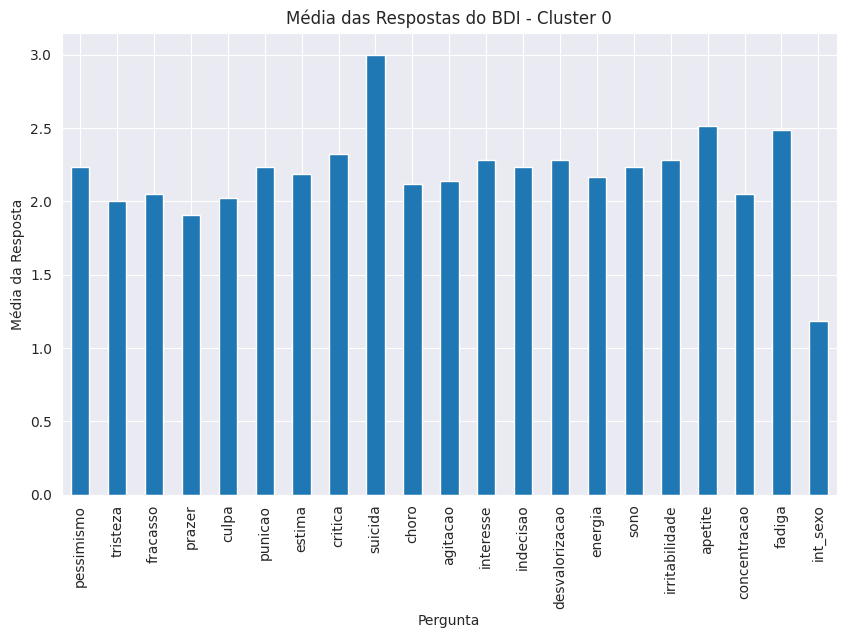

pessimismo        2.285714
tristeza          2.000000
fracasso          2.857143
prazer            2.000000
culpa             1.714286
punicao           2.428571
estima            2.857143
critica           2.857143
suicida           3.000000
choro             2.428571
agitacao          1.857143
interesse         2.285714
indecisao         2.571429
desvalorizacao    2.714286
energia           2.285714
sono              2.142857
irritabilidade    2.142857
apetite           2.428571
concentracao      2.142857
fadiga            2.714286
int_sexo          1.714286
dtype: float64


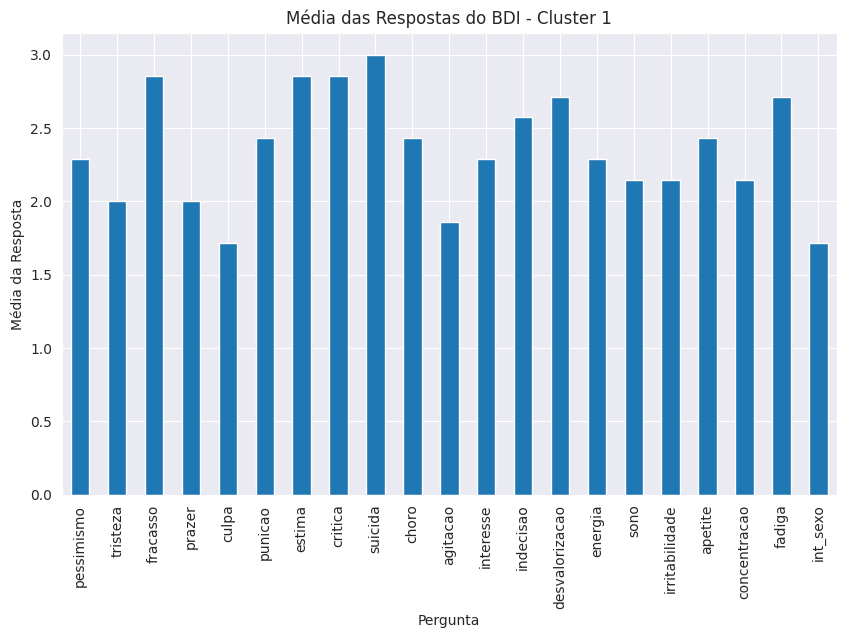

pessimismo        2.409091
tristeza          1.909091
fracasso          2.227273
prazer            2.000000
culpa             2.045455
punicao           2.090909
estima            2.318182
critica           2.409091
suicida           3.000000
choro             2.500000
agitacao          1.727273
interesse         2.090909
indecisao         2.363636
desvalorizacao    2.363636
energia           2.409091
sono              2.227273
irritabilidade    2.181818
apetite           2.500000
concentracao      2.000000
fadiga            2.409091
int_sexo          1.454545
dtype: float64


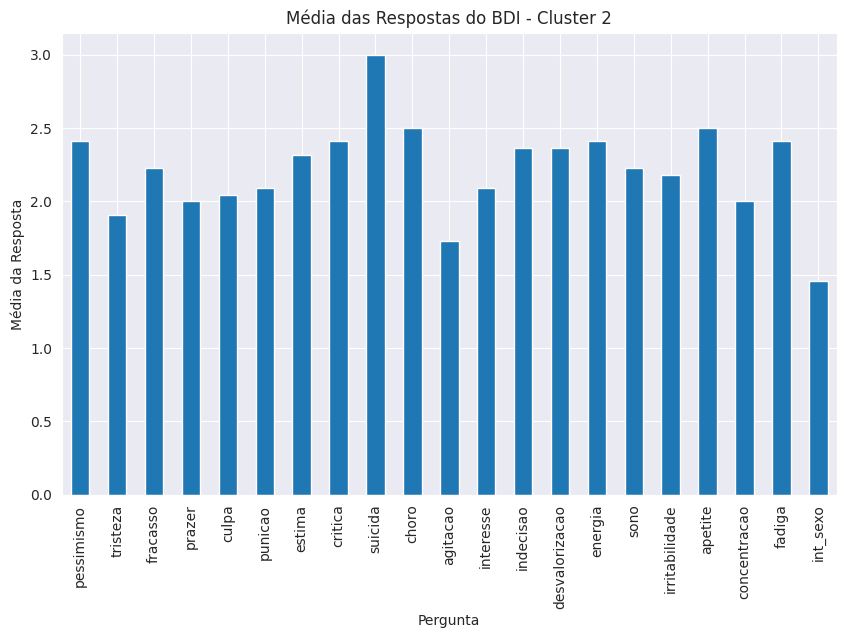

In [56]:
# Aplicando para o cluster 0
media_respostas_cluster0 = calcular_e_plotar_media_respostas_bdi(df_cluster0, "Cluster 0")

# Aplicando para o cluster 1
media_respostas_cluster1 = calcular_e_plotar_media_respostas_bdi(df_cluster1, "Cluster 1")

# Aplicando para o cluster 2
media_respostas_cluster2 = calcular_e_plotar_media_respostas_bdi(df_cluster2, "Cluster 2")

In [57]:
def calcular_e_plotar_media_interacoes(df_cluster, nome_cluster):
    df_interacoes = df_cluster.groupby(['id_usuario']).agg(
        quant_profile=('quantProfile', 'sum'),
        quant_cover=('quantCover', 'sum'),
        quant_photo_with_others=('quantAddPhotoWithOthers', 'sum'),
        quant_is_with_others=('quantIsWithOthers', 'sum'),
        quant_add_photo=('quantAddPhoto', 'sum'),
        quant_shared_photo=('quantSharedPhoto', 'sum'),
        quant_shared_video=('quantSharedVideo', 'sum'),
        quant_shared_link=('quantSharedLink', 'sum'),
        quant_shared_post=('quantSharedPost', 'sum'),
        quant_shared_event=('quantSharedEvent', 'sum'),
        quant_shared_memory=('quantSharedMemory', 'sum'),
        quant_status=('quantStatus', 'sum'),
    ).reset_index()

    # Remover a coluna 'id_usuario'
    df_media_interacoes = df_interacoes.drop(columns=['id_usuario'])

    # Calcular a média de cada interação
    media_interacoes = df_media_interacoes.mean()

    print(media_interacoes)

    # Plotar as médias
    plt.figure(figsize=(10, 6))
    media_interacoes.plot(kind='bar')
    plt.xlabel('Tipo de Interação')
    plt.ylabel('Média da Interação')
    plt.title(f'Média das Interações - {nome_cluster}')
    plt.show()

    # Retornar as médias
    return media_interacoes

quant_profile               2.906977
quant_cover                 1.906977
quant_photo_with_others     4.116279
quant_is_with_others       10.023256
quant_add_photo             2.069767
quant_shared_photo         30.674419
quant_shared_video         21.186047
quant_shared_link           3.534884
quant_shared_post          29.674419
quant_shared_event          0.139535
quant_shared_memory         3.651163
quant_status                0.465116
dtype: float64


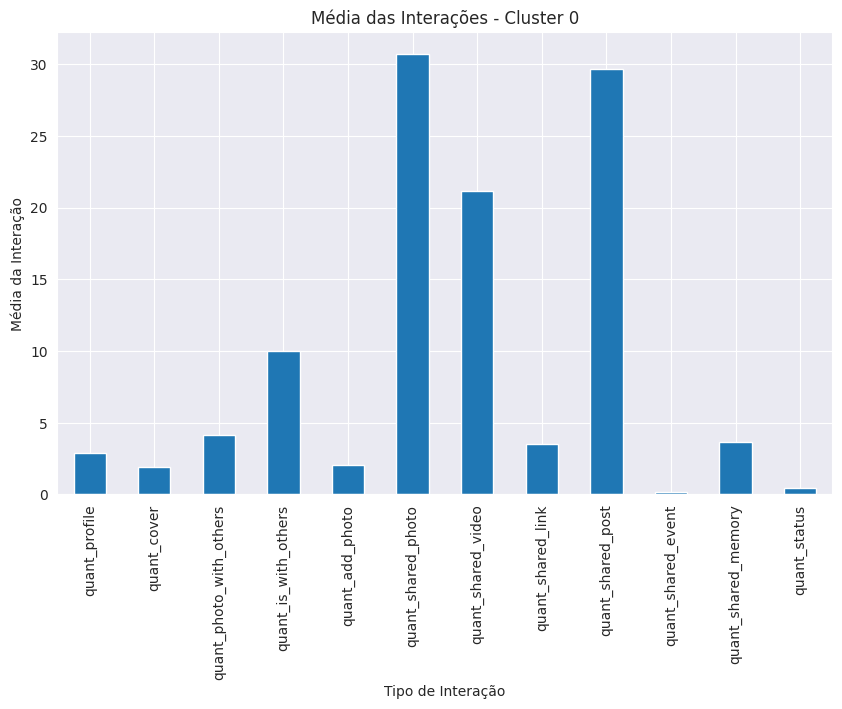

quant_profile                3.571429
quant_cover                  0.714286
quant_photo_with_others      4.571429
quant_is_with_others        31.285714
quant_add_photo             21.285714
quant_shared_photo         313.571429
quant_shared_video         121.142857
quant_shared_link           12.428571
quant_shared_post          363.285714
quant_shared_event           1.000000
quant_shared_memory         18.714286
quant_status                 3.714286
dtype: float64


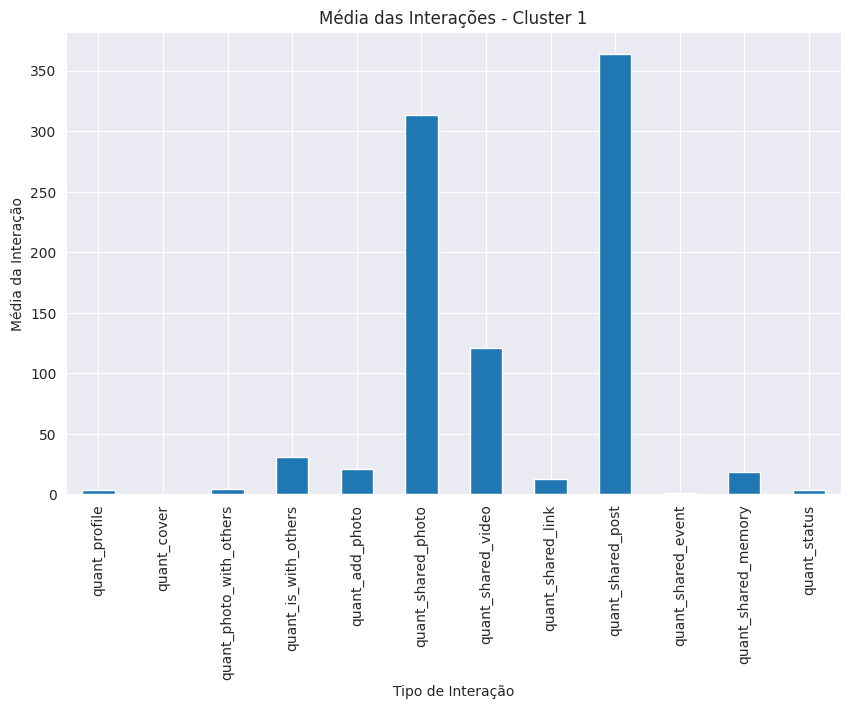

quant_profile                6.363636
quant_cover                  1.545455
quant_photo_with_others      3.727273
quant_is_with_others        18.363636
quant_add_photo              3.454545
quant_shared_photo         175.318182
quant_shared_video          77.454545
quant_shared_link           10.863636
quant_shared_post          178.863636
quant_shared_event           0.681818
quant_shared_memory          8.772727
quant_status                 3.409091
dtype: float64


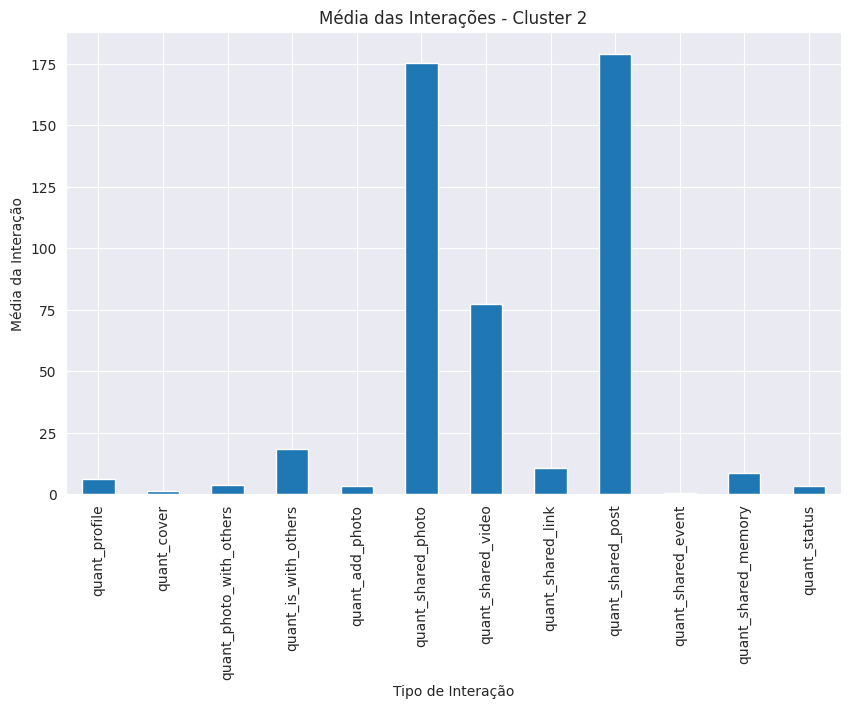

In [58]:
# Aplicando para o cluster 0
media_interacoes_cluster0 = calcular_e_plotar_media_interacoes(df_cluster0, "Cluster 0")

# Aplicando para o cluster 1
media_interacoes_cluster1 = calcular_e_plotar_media_interacoes(df_cluster1, "Cluster 1")

# Aplicando para o cluster 2
media_interacoes_cluster2 = calcular_e_plotar_media_interacoes(df_cluster2, "Cluster 2")

# Likes

In [59]:
df_likes_cluster0 = df_likes[df_likes['id_usuario'].isin(post_count[post_count['cluster'] == 0]['id_usuario'])]
df_likes_cluster1 = df_likes[df_likes['id_usuario'].isin(post_count[post_count['cluster'] == 1]['id_usuario'])]
df_likes_cluster2 = df_likes[df_likes['id_usuario'].isin(post_count[post_count['cluster'] == 2]['id_usuario'])]

In [60]:
df_likes_cluster0.to_csv('df_likes_cluster0.csv', index=False)
df_likes_cluster1.to_csv('df_likes_cluster1.csv', index=False)
df_likes_cluster2.to_csv('df_likes_cluster2.csv', index=False)

In [61]:
like_count_cluster0 = df_likes_cluster0.groupby('id_usuario').size().reset_index(name='quant_like_cluster0')
like_count_cluster1 = df_likes_cluster1.groupby('id_usuario').size().reset_index(name='quant_like_cluster1')
like_count_cluster2 = df_likes_cluster2.groupby('id_usuario').size().reset_index(name='quant_like_cluster2')

Usuário 1870214326566563 não tem observações suficientes para decomposição. Necessário: 14, disponível: 5
Usuário 480921808961652 não tem observações suficientes para decomposição. Necessário: 14, disponível: 5
Usuário 1366517723470379 não tem observações suficientes para decomposição. Necessário: 14, disponível: 3
Usuário 1959090184414965 não tem observações suficientes para decomposição. Necessário: 14, disponível: 6
Usuário 505494126499653 não tem observações suficientes para decomposição. Necessário: 14, disponível: 11
Usuário 299741130514772 não tem observações suficientes para decomposição. Necessário: 14, disponível: 4
trend
no trend      19
decreasing    10
increasing     7
Name: count, dtype: int64
trend
no trend      52.777778
decreasing    27.777778
increasing    19.444444
Name: count, dtype: float64


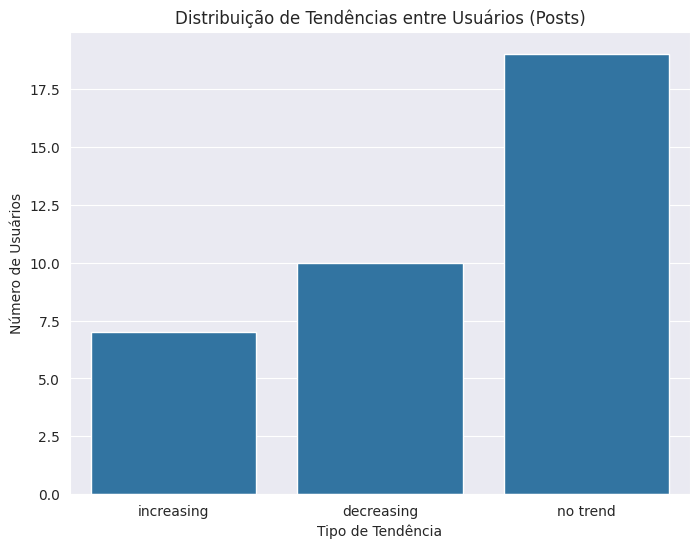

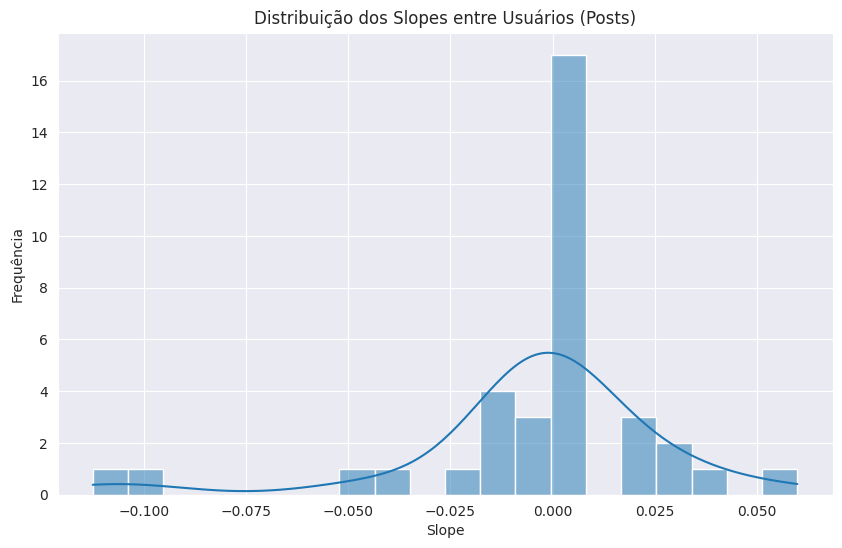

trend
no trend      4
increasing    2
decreasing    1
Name: count, dtype: int64
trend
no trend      57.142857
increasing    28.571429
decreasing    14.285714
Name: count, dtype: float64


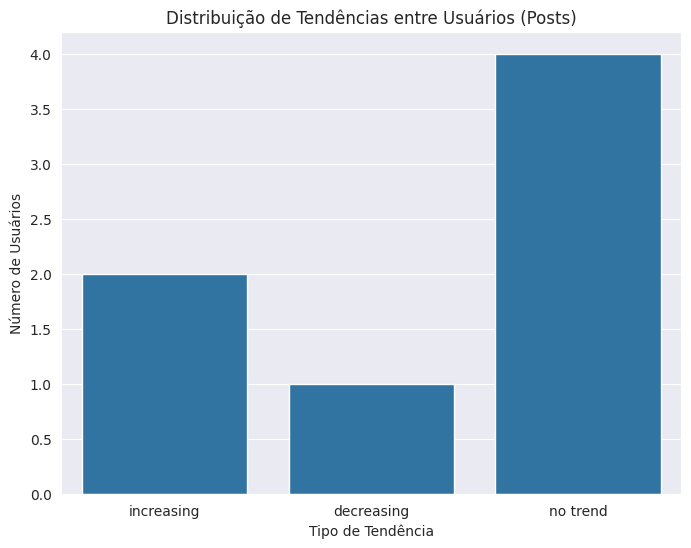

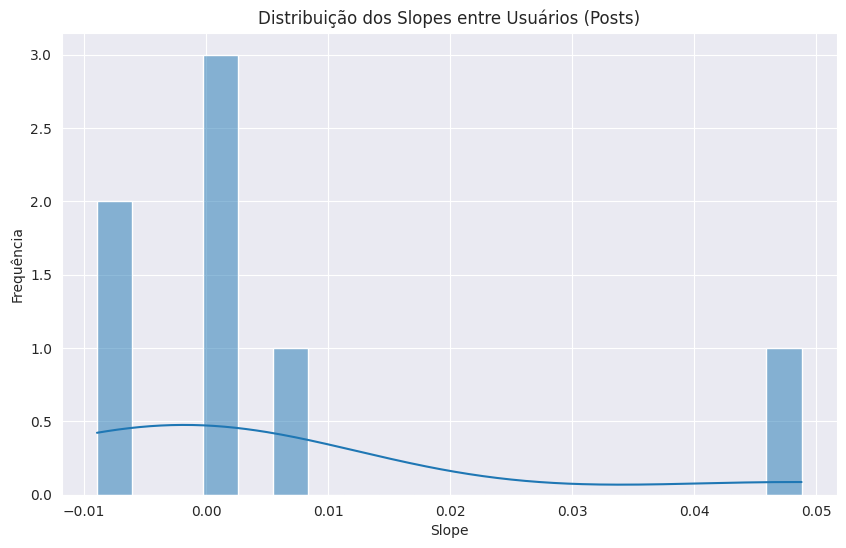

trend
decreasing    11
no trend       8
increasing     3
Name: count, dtype: int64
trend
decreasing    50.000000
no trend      36.363636
increasing    13.636364
Name: count, dtype: float64


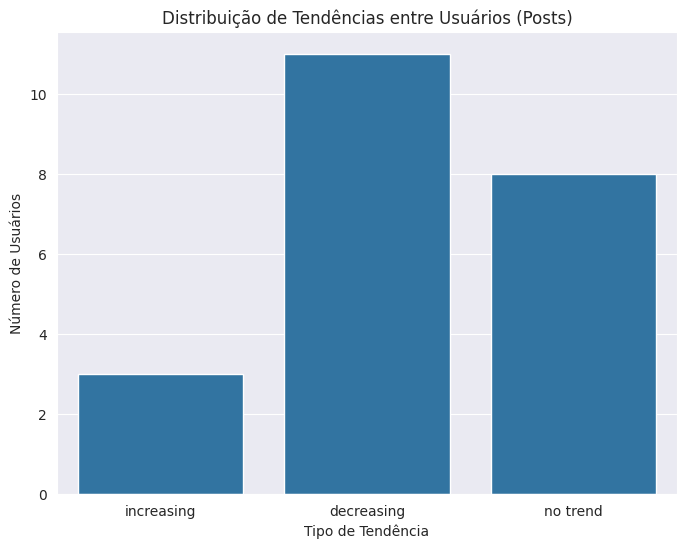

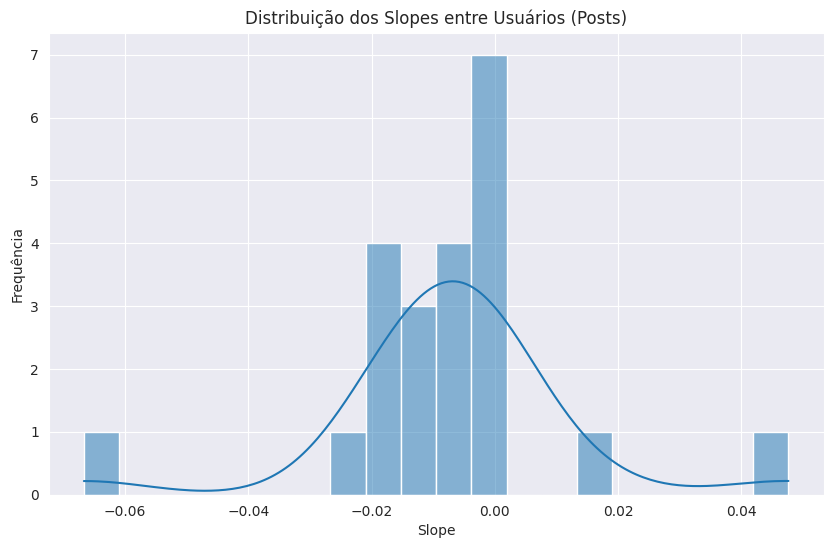

In [62]:
resultados_mk_like_cluster0 = decompor_e_teste_mk(df_likes_cluster0, 7)
resultados_mk_like_cluster1 = decompor_e_teste_mk(df_likes_cluster1, 7)
resultados_mk_like_cluster2 = decompor_e_teste_mk(df_likes_cluster2, 7)